# Getting Principal Components

In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca, align


topology_file = "/home/uni/bioemu/2k39-bioemu-200-samples/PDBs/topology-1200-odd-atoms.pdb"
trajectory_file = "/home/uni/bioemu/2k39-bioemu-200-samples/PDBs/visualization-1200-odd-atoms/combined-samples-trajectory.pdb"
u = mda.Universe(topology_file, trajectory_file)
n_pc = None # number of principal components to compute; None means all components

# Align the trajectory to the first frame using the backbone atoms. This is necessary for PCA to ensure that the analysis is not affected by translational and rotational motion and to focus on the conformational changes of the protein.
aligner = align.AlignTraj(u, u, select='backbone', in_memory=True).run()

pca_analysis = pca.PCA(u, select='backbone', align=True, mean=None, n_components=n_pc).run()

backbone = u.select_atoms('backbone')
bb_count = len(backbone)
print(f"Number of backbone atoms: {bb_count}")
print(pca_analysis.p_components.shape)

# variance of each component
for i, variance in enumerate(pca_analysis.variance):
    print(f"Variance {i+1}: {variance}")

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='MDAnalysis') # looks like biopython, a dependency has some sort of deprecation; uncomment this line to find out 

/home/uni/miniconda3/lib/python3.13/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


Number of backbone atoms: 304
(912, 912)
Variance 1: 214.65296659596473
Variance 2: 202.4364130634726
Variance 3: 87.45838684525197
Variance 4: 36.68733564788387
Variance 5: 21.59001391510036
Variance 6: 13.519342214077424
Variance 7: 11.542732349899493
Variance 8: 9.131482720518491
Variance 9: 8.559629815915214
Variance 10: 7.7648756215173105
Variance 11: 6.258530534001775
Variance 12: 5.6773904849711565
Variance 13: 4.960197695935209
Variance 14: 4.636761129575411
Variance 15: 4.287851250603124
Variance 16: 3.988551016203273
Variance 17: 3.582606626396963
Variance 18: 3.2547555268219632
Variance 19: 3.133518085644717
Variance 20: 2.987875675623034
Variance 21: 2.8986334532736775
Variance 22: 2.7382785166520667
Variance 23: 2.448228060647673
Variance 24: 2.3771025956581426
Variance 25: 2.186364740980222
Variance 26: 2.0103684179617156
Variance 27: 1.948545218459949
Variance 28: 1.8460092969305733
Variance 29: 1.7483730575902101
Variance 30: 1.6668919401551299
Variance 31: 1.6082909791

/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:350: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)
/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:360: DeprecationWarning: The `variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


### Plotting Eigenvectors vs Eigenvalues

/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:370: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Cumulative variance [Eigenvalue]')

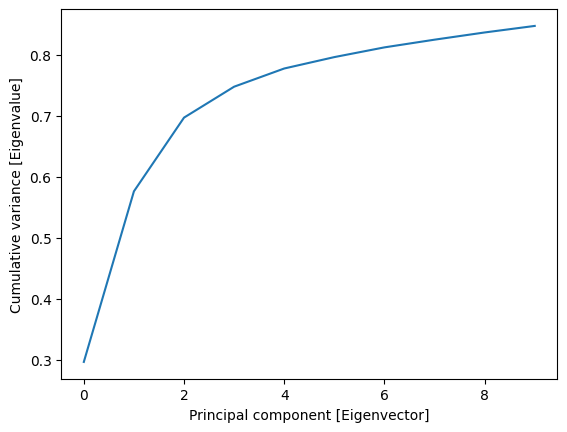

In [2]:
import matplotlib.pyplot as mplt
mplt.plot(pca_analysis.cumulated_variance[:10])
mplt.xlabel('Principal component [Eigenvector]')
mplt.ylabel('Cumulative variance [Eigenvalue]')
# mplt.show()  # uncomment to show the plot in a non interactive environment

# Reduced-dimension visualization

### Computing weights

In [3]:
# converting backbone (an atomgroup) into eigenvector (here principal component) based weight. Here the weight is the eigenvector itself scaled by the signed deviation of the coordinate from the mean (where mean could be the the coordinate of the centroid structure of the average of the all the frames coordinates for that atom):

transformed = pca_analysis.transform(backbone,n_components=3) # transformed is weights of atomgroups projected onto a principal component; each principal component gets its own set of weights for a given atomgroup
print(transformed.shape) # (n_frames, n_components)


(194, 3)


### Dataframe-ing it

In [4]:
# Now, for easy handling, we can convert the transformed to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(3)])
df['Time (ps)'] = df.index * u.trajectory.dt
# print(df.head())
# Save the transformed to a CSV file for further analysis
df.to_csv('pca_transformed.csv', index=False)

"""print(df.index)
print(df.index * u.trajectory.dt)
print(u.trajectory.dt)
print(df.head())"""

'print(df.index)\nprint(df.index * u.trajectory.dt)\nprint(u.trajectory.dt)\nprint(df.head())'

### Visualization

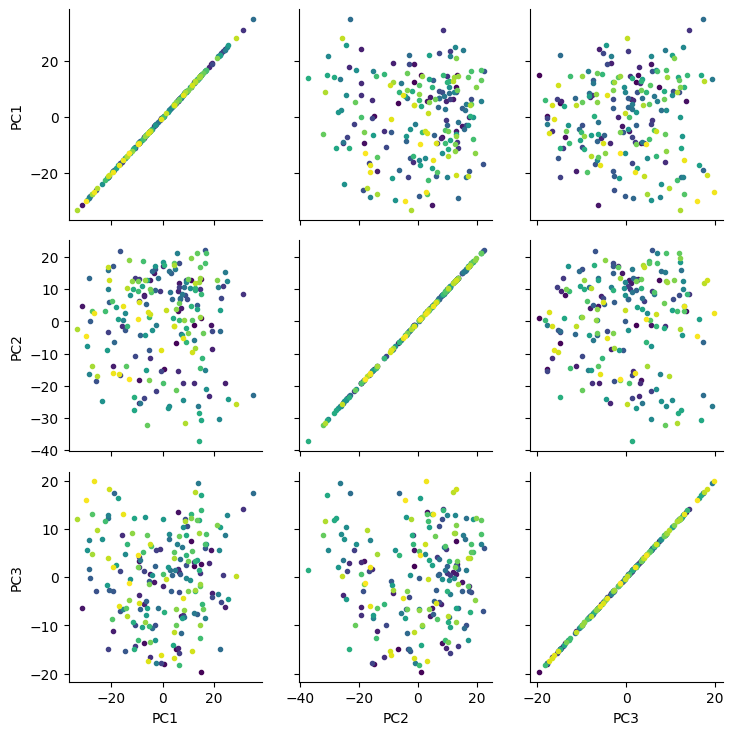

In [5]:
import seaborn as sbn

pg = sbn.PairGrid(df, hue='Time (ps)', palette=sbn.color_palette("viridis", n_colors=len(df)))
pg.map(mplt.scatter, marker='.',)
#mplt.show()  # uncomment to show the plot in a non interactive environment
# Save the pair grid plot
pg.savefig('pair_grid_plot.png')


# Projecting the original trajectory onto principal components

### Analysis

Take the outer product, load it in a new universe of just backbone. 

As an intermediary, you would need to reshape the result of the outer product to load them as coordinates in a new universe (with 1 atomgroup: backbone)

In [6]:
# Projecting the original trajectory onto the first principal component
pc1 = pca_analysis.p_components[:, 0] # all rows, and first column
transformed1 = transformed[:, 0] # all rows, and first column

import numpy
projected = numpy.outer(transformed1, pc1) + pca_analysis.mean.flatten() # flatten takes the mean coordinates from multi dimensional arrays to single dimension array 
n_frames = u.trajectory.n_frames  # number of frames in the trajectory
n_atoms = len(backbone)  # number of atoms in the backbone selection
coordinates = projected.reshape(n_frames, n_atoms, 3)
# -1 means the value there is determined based on the other two and the total number of elements. So, while the first and the last argument are given, the second dimension is asked to be determined. Here the second argument is number of atoms I think as indicated by order the a in fac in the next cell. so the reshaped dimensions represent number of principal components, number of atoms and the three spatial axes (x, y and z), responectively.
print(coordinates)
print(pc1.shape)  # Should be (n_atoms*3,)
print(coordinates.shape)  # Should be (n_frames, n_atoms, 3)
print(len(backbone))  # Should be n_atoms
proj_pc1 = mda.Merge(backbone) # creating new universe object with just backbone atoms
proj_pc1.load_new(coordinates, order='fac') # fac: f for fortran order, a for atom index, c for coordinates


[[[  8.10303999   1.1991559   11.54892242]
  [  6.77474328   1.50093712  11.97861431]
  [  5.77827211   0.52107194  11.40012261]
  ...
  [ -5.22300546   1.28579698 -17.06900636]
  [ -4.89841931   1.5971712  -17.12956673]
  [ -4.88463231   1.44498401 -17.15385631]]

 [[  8.11153058   1.25617234  11.52646265]
  [  6.78280781   1.55516535  11.95960438]
  [  5.78825189   0.56993954  11.38669869]
  ...
  [ -4.89889822   2.0599996  -17.0452692 ]
  [ -4.54620572   2.42986921 -17.09796228]
  [ -4.54164646   2.26713921 -17.13449279]]

 [[  8.07873008   1.03590872  11.61322832]
  [  6.75165324   1.34567303  12.03304276]
  [  5.74969841   0.38115617  11.43855746]
  ...
  [ -6.15097632  -0.93086898 -17.13696964]
  [ -5.90686318  -0.78697642 -17.22005534]
  [ -5.86665568  -0.90897786 -17.20929717]]

 ...

 [[  8.02958017   0.70585475  11.74324231]
  [  6.7049697    1.03175934  12.14308648]
  [  5.69192797   0.09827379  11.51626522]
  ...
  [ -8.02715237  -5.41253512 -17.27437814]
  [ -7.94573995  -

/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:350: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


<Universe with 304 atoms>

### interactive visualization

In [7]:
import nglview as ngl

view = ngl.show_mdanalysis(proj_pc1.atoms)
view

from nglview.contrib.movie import MovieMaker
movie = MovieMaker(
    view,
    step=4,  # keep every 4th frame
    output='pc1.gif',
    render_params={"factor": 3},  # set to 4 for highest quality
)
movie.make()


You have to install moviepy, imageio and ffmeg
pip install moviepy==0.2.2.11
pip install imageio==1.6


IntProgress(value=0, description='Rendering ...', max=48)

# Cosine Component

In [8]:
# cosine component of each principal component
for i in range(3):
    cosine_content = pca.cosine_content(transformed, i)
    print(f"Cosine content for PC{i+1} = {cosine_content:.3f}")

Cosine content for PC1 = 0.009
Cosine content for PC2 = 0.001
Cosine content for PC3 = 0.001


/home/uni/miniconda3/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/uni/miniconda3/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/uni/miniconda3/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


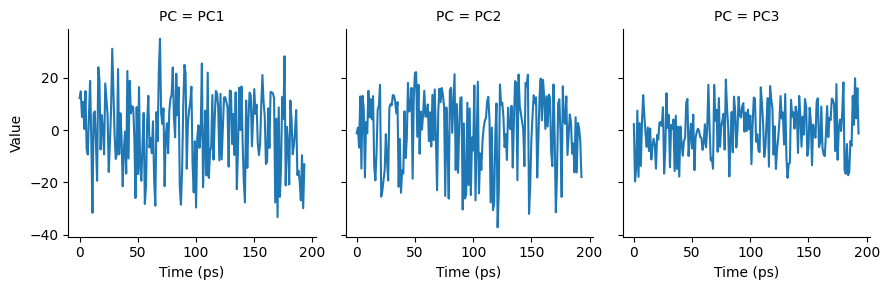

In [9]:
# data processing: melt the dataframe into a tidy format
melted = pd.melt(df, id_vars=["Time (ps)"], var_name="PC", value_name="Value")


# visualization
# Plot the metled dataframe to see the cosine form of each principal component
g = sbn.FacetGrid(melted, col="PC")
g.map(sbn.lineplot,
      "Time (ps)", # x-axis
      "Value", # y-axis
      ci=None) # No confidence interval
# mplt.show() # uncomment to show the plot in non interactive environments